In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

%aimport titanic_src.utils
%aimport titanic_src.features.transform_features
%aimport titanic_src.models.train_model
%aimport titanic_src.visualization.visualize
%aimport titanic_src.features.build_features

tm = titanic_src.models.train_model
tf = titanic_src.features.transform_features
bf = titanic_src.features.build_features
vs = titanic_src.visualization.visualize

from titanic_src.visualization.visualize import plot_learning_curves_cv, plot_learning_curves
from titanic_src.models.train_model import get_estimators, score_df, train_val_diff, find_best_voter

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [5]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

In [6]:
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler, CategoricalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

In [7]:
from titanic_src.features.transform_features import *

In [8]:
train_data = titanic_src.utils.read_csv('data/processed/final_train.csv',index_col=0)

X_train_full = train_data.loc[:,~train_data.columns.isin(['Survived'])]
y_train_full = train_data['Survived'].as_matrix()
y_train_full_nm = train_data['Survived']

# X_train, X_val ,y_train, y_val = train_test_split(X_train_full, y_train_full)

In [9]:
X_train_full.columns

Index(['Age', 'SibSp', 'Fare', 'FamilySize', 'NumOfCabins', 'Parch', 'Master.',
       'Miss.', 'Mr.', 'Mrs.', 'Offcr.', 'Royal.', 'female', 'male', 'C', 'Q',
       'S', 'A', 'B', 'C.1', 'D', 'E', 'F', 'G', 'T', 'ZZ', '1', '2', '3',
       '0_0', '15_0', '30_0', '45_0', '60_0', '75_0', 'Alone', 'Kernel',
       'Large', 'Small'],
      dtype='object')

In [10]:
test_data = titanic_src.utils.read_csv('data/processed/final_test.csv',index_col=0)
test_data['T'] = np.zeros(len(test_data))

Let's try a few classifiers with default settings and compare their accuracies.

We also need to compare the outputs of the different models - which ones make which errors.

In [11]:
models = [('DecisionTreeClassifier',DecisionTreeClassifier()),
          ('RandomForestClassifier',RandomForestClassifier()),
          ('ExtraTreesClassifier',ExtraTreesClassifier()),
          ('GradientBoostingClassifier',GradientBoostingClassifier()),
          ('AdaBoostClassifier',AdaBoostClassifier()),
          ('LogisticRegression',LogisticRegression()),
          ('MLPClassifier',MLPClassifier(max_iter=1000)),
          ('SVC_lin',SVC(kernel='linear',probability=True,gamma='auto')),
          ('SVC_rbf',SVC(probability=True,gamma='auto')),
          ('KNeighborsClassifier',KNeighborsClassifier(n_neighbors=5)),
          ('GaussianNB',GaussianNB()),
          ('GaussianProcessClassifier',GaussianProcessClassifier())]

In [12]:
results = []
cols = ['Model', 'Average CVS', 'All CVS']
for mn, model in models:
    result = [mn]
    cvs = cross_val_score(model,X_train_full,y_train_full,cv=5,scoring='accuracy',n_jobs=-1)
    cvs_ave = np.mean(cvs)
    result.append(cvs_ave)
    result.append(cvs)
    results.append(result)
results = pd.DataFrame(results,columns=cols)
results.sort_values(by='Average CVS',ascending=False)

,Model,Average CVS,All CVS
7,SVC_lin,0.827178,"[0.8379888268156425, 0.8212290502793296, 0.820..."
5,LogisticRegression,0.826054,"[0.8268156424581006, 0.8268156424581006, 0.803..."
3,GradientBoostingClassifier,0.822727,"[0.8044692737430168, 0.8156424581005587, 0.831..."
6,MLPClassifier,0.811523,"[0.7932960893854749, 0.8100558659217877, 0.808..."
4,AdaBoostClassifier,0.809263,"[0.8044692737430168, 0.7932960893854749, 0.786..."
1,RandomForestClassifier,0.795805,"[0.7877094972067039, 0.7877094972067039, 0.814..."
10,GaussianNB,0.780200,"[0.7206703910614525, 0.7541899441340782, 0.797..."
2,ExtraTreesClassifier,0.767758,"[0.7318435754189944, 0.7653631284916201, 0.786..."
0,DecisionTreeClassifier,0.762146,"[0.7262569832402235, 0.7374301675977654, 0.825..."
8,SVC_rbf,0.756535,"[0.7094972067039106, 0.7541899441340782, 0.758..."


## DecisionTreeClassifier Tuning

In [80]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))


In [81]:
dtc = tm.ModelTester(DecisionTreeClassifier(),num_columns,cat_columns)

In [82]:
params = {'max_depth':[1,4,5,7],
          'min_samples_leaf':[2,3,4,5,6,7,8],
          'criterion':['gini'],
          'min_samples_split':[2,4,7,9,],
          'max_features':np.linspace(0.3,0.8,6)}

In [83]:
dtc.set_clf_params(params)
dtc.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=2)


Starting 5 repeats of grid search procedure
Fitting 2 folds for each of 672 candidates, totalling 1344 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1344 out of 1344 | elapsed:    2.0s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [84]:
dtc.best_df_.sort_values(['clf__min_samples_leaf','clf__min_samples_split','clf__max_features','clf__max_depth'],ascending=[False,False,True,True])

,score,count,clf__min_samples_split,clf__criterion,clf__max_features,clf__min_samples_leaf,clf__max_depth,ad_action,model,params
4,0.815944,1,9,gini,0.5,7,5,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__min_samples_split': 9, 'clf__criterion'..."
0,0.827160,1,7,gini,0.3,6,4,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__min_samples_split': 7, 'clf__criterion'..."
2,0.818174,1,7,gini,0.5,5,4,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__min_samples_split': 7, 'clf__criterion'..."
3,0.817053,1,7,gini,0.5,4,4,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__min_samples_split': 7, 'clf__criterion'..."
1,0.820421,1,4,gini,0.3,2,5,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__min_samples_split': 4, 'clf__criterion'..."


In [85]:
cross_val_score(dtc.best_df_['model'].iloc[0],X_train_full,y_train_full,cv=10,scoring='accuracy').mean()

0.8136783565997048

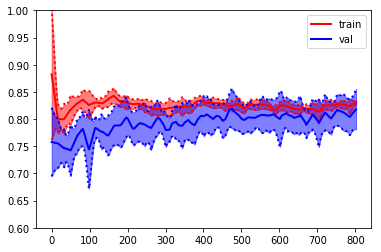

In [86]:
plot_learning_curves_cv(dtc.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,cv=10,increments=50)

In [87]:
utils.save_pipeline(dtc.best_model_,'models/grid_search_results/best_dtc.pkl')

## RandomForrestClassifier Tuning

In [58]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

In [59]:
rfc = tm.ModelTester(RandomForestClassifier(),num_columns,cat_columns)

In [68]:
params = {'bootstrap':[True],
          'max_depth':[4,5],
          'min_samples_leaf':[2,4,6,8],
          'criterion':['entropy'],
          'min_samples_split':[2,4,6,8],
          'n_estimators':[50]} #limited to 50 to give best results
         
rfc.set_clf_params(params)
rfc.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)


Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.1s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [70]:
rfc.best_df_

,score,count,clf__criterion,clf__max_depth,clf__min_samples_leaf,ad_action,clf__n_estimators,clf__bootstrap,clf__min_samples_split,model,params
0,0.833895,1,entropy,4,4,None,50,True,4,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
1,0.833895,1,entropy,5,2,None,50,True,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
2,0.833895,1,entropy,5,2,None,50,True,4,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
3,0.831650,1,entropy,4,2,None,50,True,6,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
4,0.831650,1,entropy,4,2,None,50,True,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."


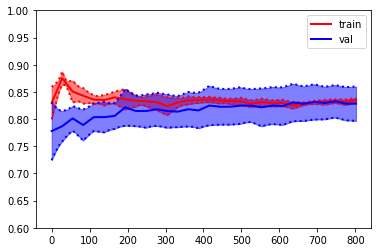

In [73]:
plot_learning_curves_cv(rfc.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,cv=10,increments=30)

In [74]:
utils.save_pipeline(rfc.best_df_['model'].iloc[0],'models/grid_search_results/best_rf.pkl')

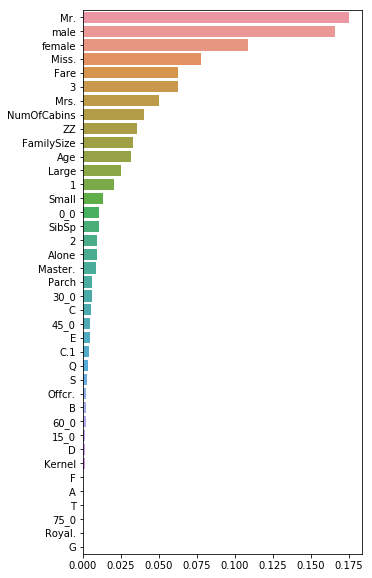

In [75]:
clf=rfc.best_df_['model'].iloc[0].steps[-1][1]
indices = list(reversed(list(np.argsort(clf.feature_importances_))))
ax = sns.barplot(x=clf.feature_importances_[indices],y=np.array(num_columns+cat_columns)[indices],orient='h')
ax.figure.set_size_inches(5,10)

In [79]:
rfc1 = tm.ModelTester(RandomForestClassifier(),num_columns,cat_columns)

params = {'bootstrap':[True],
          'max_depth':[4,5],
          'min_samples_leaf':[2,4,6,8],
          'criterion':['entropy'],
          'min_samples_split':[2,4,6,8],
          'n_estimators':[50]} #limited to 50 to give best results
         
rfc1.set_clf_params(params)
rfc1.add_additional_action(ColumnSelector(indices[:10]),clear_previous=True)
rfc1.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)


Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s


Repeat 1 of 5 done


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.1s finished


Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [80]:
rfc1.best_df_

,score,count,clf__criterion,clf__max_depth,clf__min_samples_leaf,ad_action,clf__n_estimators,clf__bootstrap,clf__min_samples_split,model,params
0,0.831650,1,entropy,5,2,"ColumnSelector(col=[23,36,30,9",50,True,8,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
1,0.830527,1,entropy,5,2,"ColumnSelector(col=[23,36,30,9",50,True,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
2,0.830527,1,entropy,5,2,"ColumnSelector(col=[23,36,30,9",50,True,6,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
3,0.828283,1,entropy,5,2,"ColumnSelector(col=[23,36,30,9",50,True,4,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."
4,0.824916,1,entropy,4,6,"ColumnSelector(col=[23,36,30,9",50,True,4,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__criterion': 'entropy', 'clf__min_sample..."


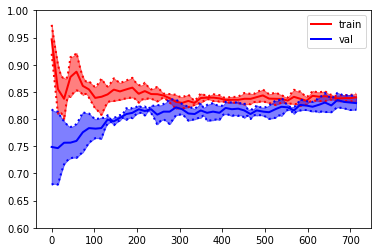

In [81]:
plot_learning_curves_cv(rfc1.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=50)

In [82]:
utils.save_pipeline(rfc1.best_df_['model'].iloc[0],'models/grid_search_results/best_rf_sel.pkl')

## GradientBoostingClassifier Tuning

In [179]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

gbc = tm.ModelTester(GradientBoostingClassifier(),num_columns,cat_columns)

In [181]:
gbc.set_clf_params({'learning_rate':[0.1],
                    'max_depth':[1,2],
                    'min_samples_leaf':[5,6,7],
                    'min_samples_split':[5,6,7],
                    'n_estimators':list(range(100,400,50)),
                    'max_features':np.linspace(0.1,1,5)})
gbc.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)


Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   31.2s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [182]:
gbc.best_df_

,score,count,clf__min_samples_leaf,clf__min_samples_split,clf__max_features,ad_action,clf__n_estimators,clf__learning_rate,clf__max_depth,model,params
0,0.836139,1,6,7,0.1,None,200,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
1,0.835017,3,7,5,1.0,None,350,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
2,0.835017,1,7,7,0.1,None,150,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."


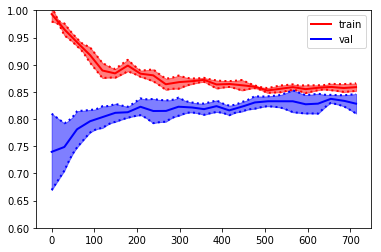

In [434]:
plot_learning_curves_cv(gbc.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=25)

In [437]:
utils.save_pipeline(gbc.best_model_,'models/grid_search_results/best_gbc.pkl')

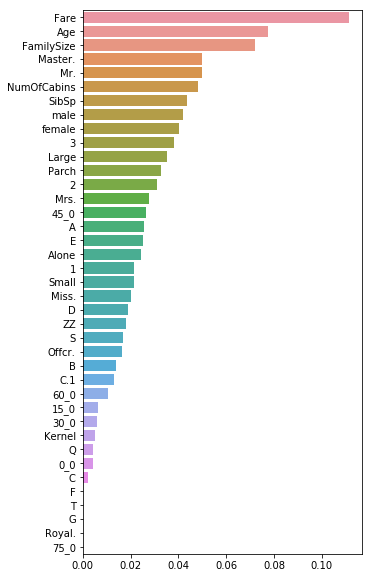

In [438]:
clf=gbc.best_model_.steps[-1][1]
indices = list(reversed(list(np.argsort(clf.feature_importances_))))
ax = sns.barplot(x=clf.feature_importances_[indices],y=np.array(num_columns+cat_columns)[indices],orient='h')
ax.figure.set_size_inches(5,10)

In [456]:
gbc1 = tm.ModelTester(GradientBoostingClassifier(),num_columns,cat_columns)

gbc1.add_additional_action(ColumnSelector(indices[:-11]),clear_previous=True)

gbc1.set_clf_params({'learning_rate':[0.1],
                    'max_depth':[1,2],
                    'min_samples_leaf':[5,6,7],
                    'min_samples_split':[5,6,7],
                    'n_estimators':list(range(100,400,50)),
                    'max_features':np.linspace(0.1,1,5)})
gbc1.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)

Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   30.7s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [457]:
gbc1.best_df_

,score,count,clf__min_samples_leaf,clf__min_samples_split,clf__max_features,ad_action,clf__n_estimators,clf__learning_rate,clf__max_depth,model,params
0,0.835017,1,5,5,0.1,"ColumnSelector(col=[1,0,3,8,37",100,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
1,0.833895,1,6,7,0.1,"ColumnSelector(col=[1,0,3,8,37",150,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
2,0.833895,1,5,5,0.1,"ColumnSelector(col=[1,0,3,8,37",150,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
3,0.832772,1,6,6,0.1,"ColumnSelector(col=[1,0,3,8,37",150,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."
4,0.832772,1,5,6,0.1,"ColumnSelector(col=[1,0,3,8,37",100,0.1,2,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__learning_rate': 0.1, 'clf__n_estimators..."


In [444]:
cross_val_score(gbc1.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,scoring='accuracy',cv=StratifiedKFold(n_splits=10,random_state=4)).mean()

0.8283356032232436

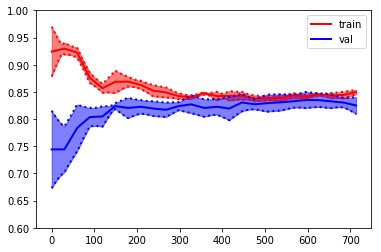

In [458]:
plot_learning_curves_cv(gbc1.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,cv=5,increments=25)

In [463]:
utils.save_pipeline(gbc1.best_df_['model'].iloc[0],'models/grid_search_results/best_gbc_sel.pkl')

## AdaBoostClassifier tuning

In [42]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))


abc = tm.ModelTester(AdaBoostClassifier(),num_columns,cat_columns)

In [43]:
abc.set_clf_params({'base_estimator':[DecisionTreeClassifier(max_depth=1,criterion='gini')],
                    'base_estimator__min_samples_leaf':[2,3,4,5,6],
                    'base_estimator__min_samples_split':[2,3,4,5],
                    'learning_rate':[1,0.1,0.01,0.001],
                    'n_estimators':list(range(50,500,50)),})
abc.do_grid_search(X=X_train_full,y=y_train_full,repeats=1,scoring='accuracy',cv=3)


Starting 1 repeats of grid search procedure
Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1270 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.5min finished


Repeat 1 of 1 done


In [44]:
abc.best_df_

,score,count,clf__base_estimator,ad_action,...base_estimator__min_samples_split,clf__n_estimators,clf__learning_rate,...base_estimator__min_samples_leaf,model,params
0,0.826038,1,DecisionTreeClassifier(class_w,None,2,50,1,3,"Pipeline(memory=None,\n steps=[('union', F...",{'clf__base_estimator': DecisionTreeClassifier...


In [45]:
cross_val_score(abc.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,scoring='accuracy',cv=StratifiedKFold(n_splits=10,random_state=4)).mean()

0.8126168993303825

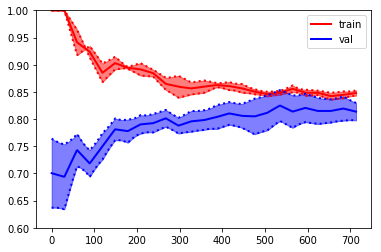

In [46]:
plot_learning_curves_cv(abc.best_model_,X_train_full,y_train_full_nm,accuracy_score,increments=25)

In [48]:
utils.save_pipeline(abc.best_model_,'models/grid_search_results/best_abc.pkl')

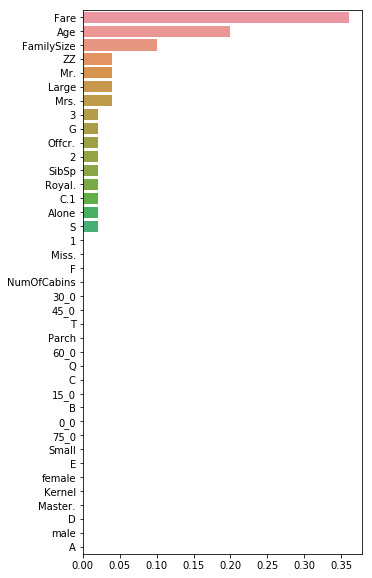

In [49]:
clf=abc.best_model_.steps[-1][1]
indices = list(reversed(list(np.argsort(clf.feature_importances_))))
ax = sns.barplot(x=clf.feature_importances_[indices],y=np.array(num_columns+cat_columns)[indices],orient='h')
ax.figure.set_size_inches(5,10)

In [51]:
abc1 = tm.ModelTester(AdaBoostClassifier(),num_columns,cat_columns)

abc1.add_additional_action(ColumnSelector(indices[:7]),clear_previous=True)

abc1.set_clf_params({'base_estimator':[DecisionTreeClassifier(max_depth=1,criterion='gini')],
                    'base_estimator__min_samples_leaf':[2,3,4,5,6],
                    'base_estimator__min_samples_split':[2,3,4,5],
                    'learning_rate':[1,0.1,0.01,0.001],
                    'n_estimators':list(range(50,500,50)),})
abc1.do_grid_search(X=X_train_full,y=y_train_full,repeats=1,scoring='accuracy',cv=3)


Starting 1 repeats of grid search procedure
Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.2min finished


Repeat 1 of 1 done


In [53]:
abc1.best_df_


,score,count,clf__base_estimator,ad_action,...base_estimator__min_samples_split,clf__n_estimators,clf__learning_rate,...base_estimator__min_samples_leaf,model,params
0,0.821549,1,DecisionTreeClassifier(class_w,"ColumnSelector(col=[1,0,3,20,2",2,350,0.01,2,"Pipeline(memory=None,\n steps=[('union', F...",{'clf__base_estimator': DecisionTreeClassifier...


In [54]:
cross_val_score(abc1.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,scoring='accuracy',cv=StratifiedKFold(n_splits=10,random_state=4)).mean()

0.8215185563500171

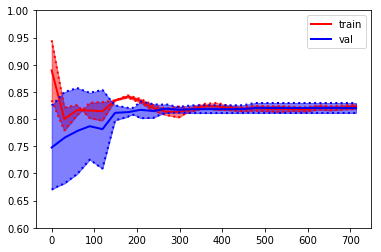

In [55]:
plot_learning_curves_cv(abc1.best_model_,X_train_full,y_train_full_nm,accuracy_score,increments=25)

In [57]:
utils.save_pipeline(abc1.best_model_,'models/grid_search_results/best_abc_sel.pkl')

## LogisticRegression tuning

In [487]:
from sklearn.feature_selection import RFECV
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))


lgc = tm.ModelTester(ColumnSelector([list(range(len(num_columns + cat_columns)))]),num_columns,cat_columns)
clf = lgc._make_model_pipeline()

In [488]:
num_pipe = Pipeline([
            ('num_selector', DataFrameSelector(num_columns)),
            ('scaler', QuantileTransformer(output_distribution='normal')),
])
union = FeatureUnion([
            ('num_pipe', num_pipe),
            ('cat_selector', DataFrameSelector(cat_columns))
])

X_train_new = union.fit_transform(X_train_full)

In [489]:
params = {'estimator__C':[0.9,0.99],
          'estimator__penalty':['l2','l1'],
          'estimator__max_iter':[1000],
          'estimator__fit_intercept':[True,False],
          'estimator__intercept_scaling':[0.1,0.5,1,2,3,4],
          'estimator__class_weight':[None,'balanced'],
          'estimator__dual':[False]}

clf = LogisticRegression()
estimator = RFECV(clf,scoring='accuracy',cv=5)
grid_search = GridSearchCV(estimator,param_grid=params,cv=3,n_jobs=-1,verbose=1)
grid_search.fit(X_train_full,y_train_full)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   35.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__intercept_scaling': [0.1, 0.5, 1, 2, 3, 4], 'estimator__max_iter': [1000], 'estimator__class_weight': [None, 'balanced'], 'estimator__dual': [False], 'estimator__C': [0.9, 0.99], 'estimator__penalty': ['l2', 'l1'], 'estimator__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [490]:
selected_colums = np.array(range(39))[grid_search.best_estimator_.support_]

0.83616035537436

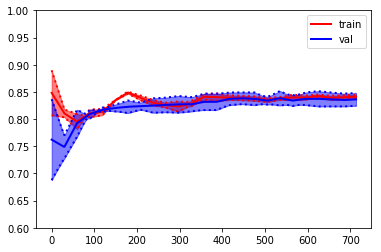

In [524]:
plot_learning_curves_cv(grid_search.best_estimator_.estimator_,X_train_full.iloc[:,grid_search.best_estimator_.support_],y_train_full_nm,accuracy_score,increments=25)
cross_val_score(grid_search.best_estimator_.estimator_,X_train_full.iloc[:,grid_search.best_estimator_.support_],y_train_full_nm,cv=5).mean()

In [515]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

lgc = tm.ModelTester(LogisticRegression(),num_columns,cat_columns)

In [517]:
lgc.add_additional_action(ColumnSelector(col=selected_colums),clear_previous=True)

lgc.set_scalers([QuantileTransformer(output_distribution='normal'),StandardScaler()])
lgc.set_clf_params({'C':[0.9,0.99],
                    'penalty':['l2','l1'],
                    'max_iter':[1000],
                    'fit_intercept':[True,False],
                    'intercept_scaling':[0.1,0.5,1,2,3,4],
                    'class_weight':[None,'balanced'],
                    'dual':[False]})

In [518]:
lgc.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=2)

Starting 5 repeats of grid search procedure
Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s


Repeat 1 of 5 done


[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    1.3s finished


Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [519]:
lgc.best_df_

,score,count,clf__penalty,...num_pipe__scaler,clf__max_iter,clf__class_weight,clf__dual,ad_action,clf__C,clf__intercept_scaling,clf__fit_intercept,model,params
0,0.826042,5,l2,"QuantileTransformer(copy=True,",1000,None,False,"ColumnSelector(col=array([6,8,",0.99,2,True,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__penalty': 'l2', 'union__num_pipe__scale..."


0.8282981500397231

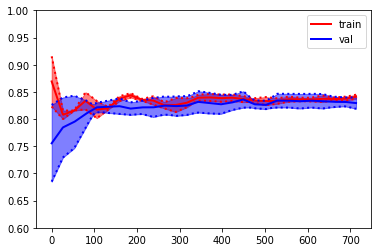

In [527]:
plot_learning_curves_cv(lgc.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=28)
cross_val_score(lgc.best_df_['model'].iloc[0],X_train_full,y_train_full,cv=10).mean()

In [528]:
utils.save_pipeline(lgc.best_model_,'models/grid_search_results/best_lgc.pkl')

## SVC_lin Tuning

In [15]:
from sklearn.feature_selection import RFECV
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))


svc_lin = tm.ModelTester(ColumnSelector([list(range(len(num_columns + cat_columns)))]),num_columns,cat_columns)
clf = svc_lin._make_model_pipeline()

In [16]:
num_pipe = Pipeline([
            ('num_selector', DataFrameSelector(num_columns)),
            ('scaler', StandardScaler()),
])
union = FeatureUnion([
            ('num_pipe', num_pipe),
            ('cat_selector', DataFrameSelector(cat_columns))
])

X_train_new = union.fit_transform(X_train_full)

In [17]:
params = {'estimator__kernel':['linear'],
          'estimator__C':[1,0.9,0.99],
          'estimator__degree':[2],
          'estimator__gamma':['auto'],
          'estimator__class_weight':[None],
          'estimator__shrinking':[True]}



clf = SVC(probability=True)
estimator = RFECV(clf,scoring='accuracy',cv=5)
grid_search = GridSearchCV(estimator,param_grid=params,cv=3,n_jobs=-1,verbose=1)
grid_search.fit(X_train_full,y_train_full)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 12.1min remaining: 15.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 25.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RFECV(cv=5,
   estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__class_weight': [None], 'estimator__degree': [2], 'estimator__C': [1, 0.9, 0.99], 'estimator__shrinking': [True], 'estimator__gamma': ['auto'], 'estimator__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [18]:
grid_search.best_params_

{'estimator__C': 0.9,
 'estimator__class_weight': None,
 'estimator__degree': 2,
 'estimator__gamma': 'auto',
 'estimator__kernel': 'linear',
 'estimator__shrinking': True}

In [19]:
selected_colums = np.array(range(39))[grid_search.best_estimator_.support_]

In [20]:
cross_val_score(grid_search.best_estimator_.estimator_,X_train_new[:,grid_search.best_estimator_.support_],y_train_full_nm,scoring='accuracy',cv=StratifiedKFold(n_splits=10,random_state=4)).mean()

0.8282604131199637

In [21]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

svc_lin = tm.ModelTester(SVC(probability=True),num_columns,cat_columns)


In [23]:
svc_lin.add_additional_action(ColumnSelector(col=selected_colums),clear_previous=True)

svc_lin.set_scalers([StandardScaler()])
svc_lin.set_clf_params({'kernel':['linear'],
                          'C':[0.9,0.99],
                          'degree':[2],
                          'gamma':['auto'],
                          'class_weight':[None,'balanced'],
                          'shrinking':[True,False]}
)

In [24]:
svc_lin.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)

Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [25]:
svc_lin.best_df_

,score,count,ad_action,clf__degree,clf__C,clf__kernel,clf__gamma,clf__shrinking,clf__class_weight,...num_pipe__scaler,model,params
0,0.823793,5,"ColumnSelector(col=array([0,1,",2,0.9,linear,auto,True,None,"StandardScaler(copy=True,with_","Pipeline(memory=None,\n steps=[('union', F...","{'clf__C': 0.9, 'clf__kernel': 'linear', 'clf_..."


In [26]:
cross_val_score(svc_lin.best_model_,X_train_full,y_train_full,scoring='accuracy').mean()

0.8237934904601572

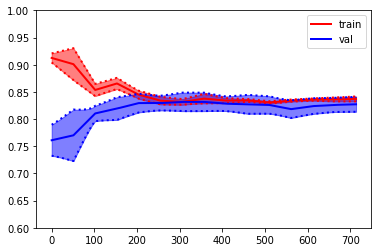

In [32]:
plot_learning_curves_cv(svc_lin.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=15)

In [33]:
utils.save_pipeline(svc_lin.best_model_,'models/grid_search_results/best_svc_lin.pkl')

## SVC_rbf Tuning

In [39]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

svc_rbf = tm.ModelTester(SVC(probability=True),num_columns,cat_columns)


In [47]:
svc_rbf.set_scalers([StandardScaler(),QuantileTransformer(output_distribution='normal')])
svc_rbf.set_clf_params({'kernel':['rbf'],
                          'C':[0.9,0.99,0.8,0.7,0.6,0.5],
                          'degree':[2],
                          'gamma':['auto'],
                          'class_weight':[None,'balanced'],
                          'shrinking':[True,False]}
)

In [48]:
svc_rbf.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)

Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    3.1s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [49]:
svc_rbf.best_df_

,score,count,ad_action,clf__degree,clf__C,clf__kernel,clf__gamma,clf__shrinking,clf__class_weight,...num_pipe__scaler,model,params
0,0.833895,5,None,2,0.8,rbf,auto,True,None,"StandardScaler(copy=True,with_","Pipeline(memory=None,\n steps=[('union', F...","{'clf__C': 0.8, 'clf__kernel': 'rbf', 'clf__ga..."


In [50]:
cross_val_score(svc_rbf.best_model_,X_train_full,y_train_full,scoring='accuracy').mean()

0.8338945005611672

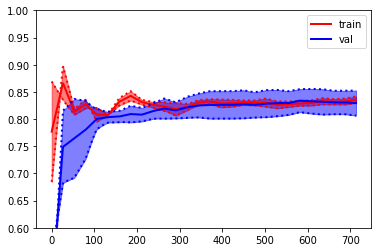

In [64]:
plot_learning_curves_cv(svc_rbf.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=28)

In [65]:
utils.save_pipeline(svc_rbf.best_model_,'models/grid_search_results/best_svc_rbf.pkl')

## SVC_poly Tuning

In [66]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

svc_poly = tm.ModelTester(SVC(probability=True),num_columns,cat_columns)


In [68]:
svc_poly.set_scalers([StandardScaler(),QuantileTransformer(output_distribution='normal')])
svc_poly.set_clf_params({'kernel':['poly'],
                          'C':[0.9,0.99,0.8,0.7,0.6,0.5],
                          'degree':[2,3],
                          'gamma':['auto'],
                          'class_weight':[None,'balanced'],
                          'shrinking':[True,False]}
)

In [69]:
svc_poly.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=3)

Starting 5 repeats of grid search procedure
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    5.3s finished


Repeat 1 of 5 done
Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [71]:
svc_poly.best_df_

,score,count,ad_action,clf__degree,clf__C,clf__kernel,clf__gamma,clf__shrinking,clf__class_weight,...num_pipe__scaler,model,params
0,0.828283,5,None,2,0.99,poly,auto,True,None,"StandardScaler(copy=True,with_","Pipeline(memory=None,\n steps=[('union', F...","{'clf__C': 0.99, 'clf__kernel': 'poly', 'clf__..."


In [72]:
cross_val_score(svc_poly.best_model_,X_train_full,y_train_full,scoring='accuracy').mean()

0.8282828282828283

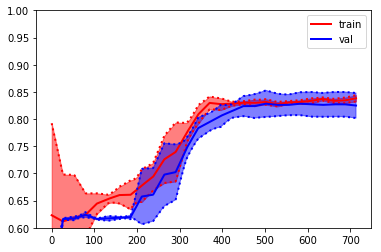

In [73]:
plot_learning_curves_cv(svc_poly.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=28)

In [74]:
utils.save_pipeline(svc_rbf.best_model_,'models/grid_search_results/best_svc_poly.pkl')

## MLPClassifier Tuning

In [118]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

mlp = tm.ModelTester(MLPClassifier(solver='lbfgs',max_iter=1000),num_columns,cat_columns)


In [119]:
mlp.add_additional_action(PCA(n_components=0.95))
mlp.set_scalers([QuantileTransformer(output_distribution='normal')])
mlp.set_clf_params({'alpha':[0.1,],
                    'hidden_layer_sizes':[(39,20,10),(39,20,10,5,),(30,15,5),]})

In [130]:
mlp.do_grid_search(X=X_train_full,y=y_train_full,repeats=3,scoring='accuracy',cv=2)

Starting 3 repeats of grid search procedure
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   13.2s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   13.8s finished


Repeat 1 of 3 done
Repeat 2 of 3 done
Repeat 3 of 3 done


In [131]:
mlp.best_df_

,score,count,clf__hidden_layer_sizes,...num_pipe__scaler,clf__alpha,ad_action,model,params
0,0.803605,1,"(30,15,5)","QuantileTransformer(copy=True,",0.1,None,"Pipeline(memory=None,\n steps=[('union', F...","{'clf__hidden_layer_sizes': (30, 15, 5), 'unio..."
1,0.775561,1,"(30,15,5)","QuantileTransformer(copy=True,",0.1,"PCA(copy=True,iterated_power='","Pipeline(memory=None,\n steps=[('union', F...","{'clf__hidden_layer_sizes': (30, 15, 5), 'unio..."
2,0.771071,1,"(39,20,10,5)","QuantileTransformer(copy=True,",0.1,"PCA(copy=True,iterated_power='","Pipeline(memory=None,\n steps=[('union', F...","{'clf__hidden_layer_sizes': (39, 20, 10, 5), '..."


In [132]:
cross_val_score(mlp.best_model_,X_train_full,y_train_full,scoring='accuracy').mean()

0.7901234567901234

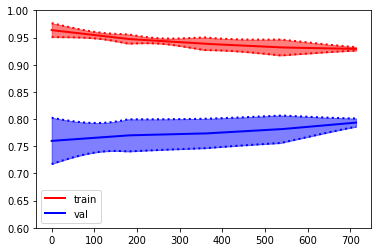

In [133]:
plot_learning_curves_cv(mlp.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,increments=5)

In [134]:
utils.save_pipeline(mlp.best_model_,'models/grid_search_results/best_mlp.pkl')

## KNeighborsClassifier Tuning

In [123]:
num_columns = ['Age','Fare','NumOfCabins','FamilySize','Parch','SibSp',]
cat_columns = list(set(X_train_full.columns) - set(num_columns))

knn = tm.ModelTester(KNeighborsClassifier(),num_columns,cat_columns)


In [124]:
knn.add_additional_action(PCA(n_components=0.95))
knn.set_scalers([StandardScaler()])
knn.set_clf_params({'n_neighbors':[5,12,13,14,15,16],
                    'weights':['uniform',],
                    'leaf_size':[10,12,15,17,20]})

In [125]:
knn.do_grid_search(X=X_train_full,y=y_train_full,repeats=5,scoring='accuracy',cv=5)

Starting 5 repeats of grid search procedure
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s


Repeat 1 of 5 done


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.0s finished


Repeat 2 of 5 done
Repeat 3 of 5 done
Repeat 4 of 5 done
Repeat 5 of 5 done


In [128]:
knn.best_df_

,score,count,clf__n_neighbors,ad_action,clf__weights,clf__leaf_size,...num_pipe__scaler,model,params
0,0.811466,5,15,"PCA(copy=True,iterated_power='",uniform,10,"StandardScaler(copy=True,with_","Pipeline(memory=None,\n steps=[('union', F...","{'clf__n_neighbors': 15, 'ad_action': PCA(copy..."


In [129]:
cross_val_score(knn.best_model_,X_train_full,y_train_full,scoring='accuracy').mean()

0.8181818181818182

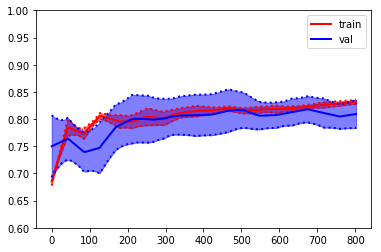

In [130]:
plot_learning_curves_cv(knn.best_df_['model'].iloc[0],X_train_full,y_train_full_nm,accuracy_score,cv=10,increments=20)

In [215]:
utils.save_pipeline(knn.best_model_,'models/grid_search_results/best_knn.pkl')

## Voting Classifier

In [21]:
from itertools import combinations
from sklearn.ensemble import VotingClassifier
import os
from scipy.special import binom
import datetime

In [88]:
all_models_path = os.listdir(os.path.join(utils.get_project_dir(),'models/grid_search_results'))
all_models = [(mod_path.split('.')[0],utils.load_pipeline(path.join('models/grid_search_results',mod_path))) for mod_path in all_models_path]

In [89]:
all_models_dict = dict(all_models)

In [90]:
results = []
cols = ['Model', 'Average CVS', 'All CVS']
for mn, model in estimators:
    result = [mn]
    cvs = cross_val_score(model,X_train_full,y_train_full,cv=10,scoring='accuracy',n_jobs=-1)
    cvs_ave = np.mean(cvs)
    result.append(cvs_ave)
    result.append(cvs)
    results.append(result)
results = pd.DataFrame(results,columns=cols)
results.sort_values(by='Average CVS',ascending=False)

,Model,Average CVS,All CVS
4,best_gbc,0.833891,"[0.8222222222222222, 0.8333333333333334, 0.775..."
5,best_gbc_sel,0.832793,"[0.8111111111111111, 0.8444444444444444, 0.775..."
0,best_svc_rbf,0.832780,"[0.8222222222222222, 0.8555555555555555, 0.786..."
1,best_svc_poly,0.832780,"[0.8222222222222222, 0.8555555555555555, 0.786..."
6,best_rf,0.832768,"[0.8333333333333334, 0.8555555555555555, 0.775..."
3,best_rf_sel,0.832755,"[0.8333333333333334, 0.8555555555555555, 0.775..."
7,best_lgc,0.828298,"[0.8222222222222222, 0.8333333333333334, 0.775..."
8,best_svc_lin,0.828260,"[0.8, 0.8777777777777778, 0.7865168539325843, ..."
2,best_dtc,0.810371,"[0.8222222222222222, 0.7888888888888889, 0.786..."


In [91]:
best_models = results.sort_values(by='Average CVS',ascending=False).iloc[:9]['Model']
estimators = [(model,all_models_dict[model]) for model in best_models]
estimator_dict = dict(estimators)

### Hard Voter

In [46]:
best_hard_score, best_hard_voter, hard_combo_score_std = find_best_voter(estimators,X_train_full,y_train_full,calc_diff=True)

Starting search for best estimator combination for voting.
Num of estimators : 9
Num of combinations : 502.0
10 % complete; 0:03:17.559650 elapsed 
20 % complete; 0:05:57.838706 elapsed 
30 % complete; 0:08:19.271681 elapsed 
40 % complete; 0:10:44.149616 elapsed 
50 % complete; 0:13:01.365320 elapsed 
60 % complete; 0:15:06.324671 elapsed 
70 % complete; 0:16:51.814273 elapsed 
80 % complete; 0:18:16.531371 elapsed 
90 % complete; 0:19:31.103719 elapsed 
100 % complete; 0:20:31.030177 elapsed 
Best score: 0.8373029948715984


In [62]:
hard_report = score_df(hard_combo_score_std,lowest_precision=3,highest_precision=3)

sorted_hard_report = hard_report.sort_values(by=['diff'],ascending=[True])

hard_estimators = get_estimators(sorted_report.iloc[0])

sorted_hard_report

,estimator,score,stdev,diff,lowest,highest
210,"['best_svc_poly','best_svc_lin']",0.833907,0.019546,0.000550,0.814,0.853
481,"['best_svc_rbf','best_svc_lin']",0.833907,0.019546,0.000550,0.814,0.853
294,"['best_svc_rbf','best_svc_poly','best_dtc','be...",0.831672,0.023163,0.000819,0.809,0.855
380,"['best_svc_rbf','best_svc_poly','best_rf_sel',...",0.833907,0.019546,0.000830,0.814,0.853
491,"['best_svc_rbf','best_svc_poly','best_rf','bes...",0.832783,0.021050,0.000830,0.812,0.854
223,"['best_svc_rbf','best_svc_poly','best_gbc_sel'...",0.832790,0.018452,0.001098,0.814,0.851
49,"['best_svc_rbf','best_svc_poly','best_gbc','be...",0.833920,0.020107,0.001379,0.814,0.854
264,"['best_svc_rbf','best_svc_poly','best_dtc','be...",0.833907,0.019546,0.001672,0.814,0.853
127,"['best_svc_rbf','best_rf','best_svc_lin']",0.833907,0.019546,0.001672,0.814,0.853
28,"['best_svc_rbf','best_svc_poly','best_lgc','be...",0.832790,0.018452,0.001948,0.814,0.851


In [92]:
best_hard_voter = [(est_key,estimator_dict[est_key]) for est_key in hard_estimators]

In [93]:
hard_voting_clf = VotingClassifier(
    estimators=best_hard_voter,
    voting='hard')

In [94]:
np.mean(cross_val_score(hard_voting_clf,X_train_full,y_train_full,cv=5,scoring='accuracy',n_jobs=-1))

0.8327770147177784

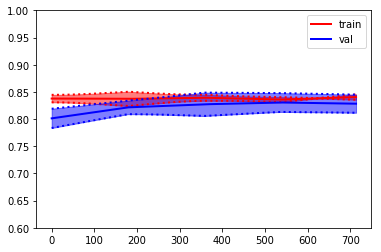

In [95]:
plot_learning_curves_cv(hard_voting_clf,X_train_full,y_train_full_nm,accuracy_score,increments=5)

### Soft Voter

In [47]:
best_soft_score, best_soft_voter, soft_combo_score_std = find_best_voter(estimators,X_train_full,y_train_full,voting='soft',cv=5,calc_diff=True)

Starting search for best estimator combination for voting.
Num of estimators : 9
Num of combinations : 502.0
10 % complete; 0:03:11.032939 elapsed 
20 % complete; 0:05:57.317509 elapsed 
30 % complete; 0:08:24.631235 elapsed 
40 % complete; 0:10:47.225461 elapsed 
50 % complete; 0:12:49.687347 elapsed 
60 % complete; 0:14:41.237915 elapsed 
70 % complete; 0:16:37.664705 elapsed 
80 % complete; 0:18:18.523060 elapsed 
90 % complete; 0:19:49.812457 elapsed 
100 % complete; 0:21:02.016262 elapsed 
Best score: 0.8384139653101459


In [98]:
utils.save_csv(soft_report,'soft_report.csv')

In [96]:
soft_report = score_df(soft_combo_score_std,lowest_precision=3,highest_precision=3)

sorted_soft_report = soft_report.sort_values(by=['diff'],ascending=[True])

soft_estimators = get_estimators(sorted_report.iloc[0])

sorted_soft_report

,estimator,score,stdev,diff,lowest,highest
416,"['best_svc_rbf','best_svc_poly','best_dtc','be...",0.837290,0.022001,0.001092,0.815,0.859
117,"['best_svc_rbf','best_svc_poly','best_lgc']",0.832790,0.018452,0.001387,0.814,0.851
448,"['best_svc_rbf','best_svc_poly','best_svc_lin']",0.832790,0.018452,0.001387,0.814,0.851
340,"['best_svc_poly','best_rf']",0.835050,0.022719,0.001653,0.812,0.858
148,"['best_svc_rbf','best_rf']",0.831679,0.020827,0.001927,0.811,0.853
32,"['best_svc_rbf','best_svc_poly']",0.832802,0.019370,0.001936,0.813,0.852
491,"['best_svc_rbf','best_svc_poly','best_rf','bes...",0.832790,0.018452,0.001948,0.814,0.851
290,"['best_svc_rbf','best_svc_poly','best_dtc','be...",0.836167,0.022689,0.002222,0.813,0.859
380,"['best_svc_rbf','best_svc_poly','best_rf_sel',...",0.832790,0.018452,0.002509,0.814,0.851
410,"['best_svc_rbf','best_svc_poly','best_dtc','be...",0.833932,0.022398,0.002782,0.812,0.856


In [69]:
best_soft_voter = [(est_key,estimator_dict[est_key]) for est_key in soft_estimators]

In [97]:
soft_voting_clf = VotingClassifier(
    estimators=best_soft_voter,
    voting='soft')

In [98]:
np.mean(cross_val_score(soft_voting_clf,X_train_full,y_train_full,cv=5,scoring='accuracy',n_jobs=-1))

0.8350493849358125

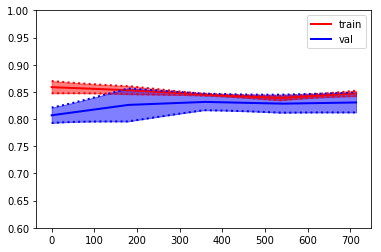

In [99]:
plot_learning_curves_cv(soft_voting_clf,X_train_full,y_train_full_nm,accuracy_score,increments=5)

In [104]:
hard_voting_clf.fit(X_train_full, y_train_full)
est_y = hard_voting_clf.predict(test_data)
test_data['Survived'] = est_y
utils.save_csv(test_data[['Survived']],'results/result_{}.csv'.format('hard_voting'))

In [105]:
soft_voting_clf.fit(X_train_full, y_train_full)
est_y = soft_voting_clf.predict(test_data)
test_data['Survived'] = est_y
utils.save_csv(test_data[['Survived']],'results/result_{}.csv'.format('soft_voting'))

In [106]:
for model, est in estimators:
    est.fit(X_train_full,y_train_full)
    est_y = est.predict(test_data)
    test_data['Survived'] = est_y
    utils.save_csv(test_data[['Survived']],'results/result_{}.csv'.format(model))
